array([[-2.06871939e+00, -5.28314725e-01],
       [-1.96977329e+00, -1.79630569e+00],
       [-6.23751929e-01, -1.25662097e+00],
       [-2.34394294e+00, -1.19672643e+00],
       [-1.81420930e+00, -2.57032981e+00],
       [-2.48659682e-01, -1.85507239e+00],
       [ 9.42552527e-02,  5.99465334e-01],
       [-2.55613134e-01, -5.17064028e-01],
       [-1.40775091e+00, -9.80813594e-01],
       [-1.39923239e+00, -8.47956792e-01],
       [ 7.29760311e-01, -1.97383319e+00],
       [-1.33458550e+00, -4.67229136e-01],
       [-1.75320450e+00, -1.15365356e+00],
       [-1.59537156e+00, -1.49849647e+00],
       [-1.58636299e+00,  7.09962715e-01],
       [-2.23096640e+00, -2.13929295e+00],
       [ 1.03005226e+00, -2.31786550e+00],
       [-6.13732689e-01,  8.89254695e-01],
       [-4.05913128e+00, -7.14834606e-01],
       [-2.23322824e+00, -1.87841195e+00],
       [ 1.07983739e+00, -1.75521992e-01],
       [ 1.18303444e+00, -6.94965214e-01],
       [-2.25295390e+00, -2.52016674e+00],
       [-2.

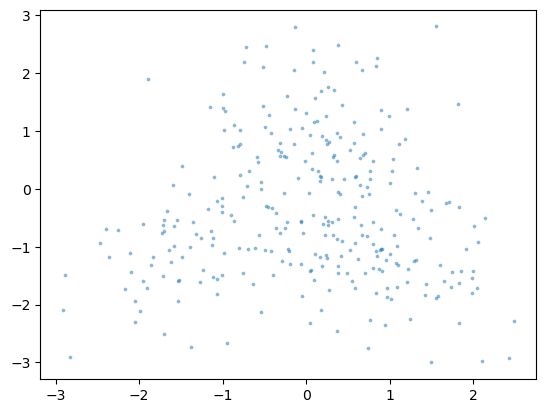

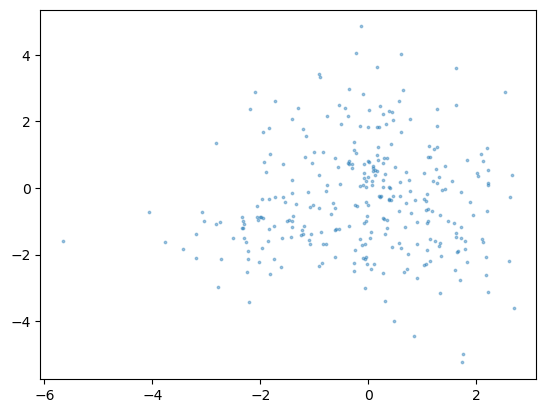

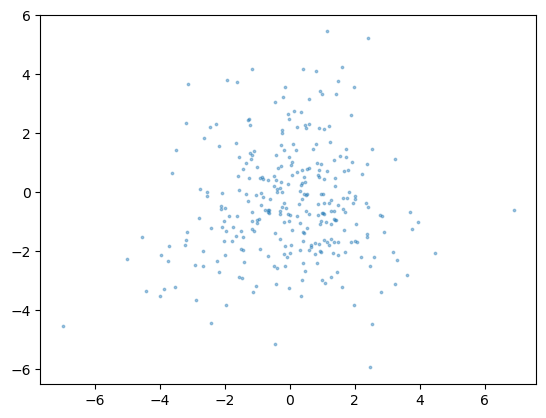

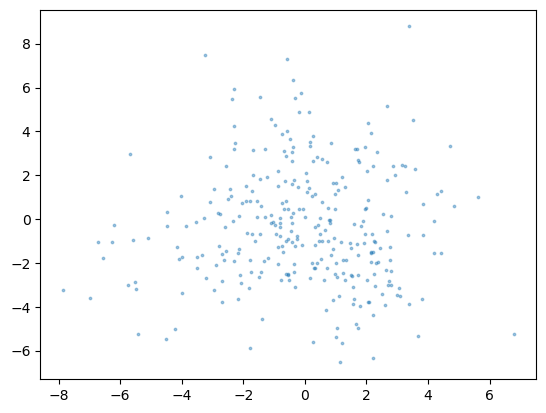

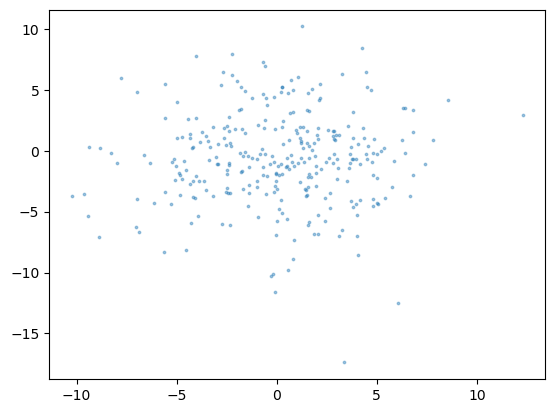

In [66]:
#generate clustering data 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from scipy.stats import multivariate_normal

def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10], s = 1):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    m1 = [-1, -1]
    m2 = [1, -1]
    m3 = [0, 1]
    cov1 = np.array([[2.0, 0.5], [0.5, 1.0]]).astype("float")
    cov2 = np.array([[1.0, -0.5], [-0.5, 2.0]]).astype("float")
    cov3 = np.array([[1.0, 0], [0, 2.0]]).astype("float")
    x = []
    A = np.random.multivariate_normal(m1, s*cov1, points_per_cluster)
    B = np.random.multivariate_normal(m2, s*cov2, points_per_cluster)
    C = np.random.multivariate_normal(m3, s*cov3, points_per_cluster)
    x = np.concatenate((A, B, C), axis=0)
    labels = np.repeat([1, 2, 3], 100).reshape(300,1)
    
    x = np.hstack((x, labels))

    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x

X_s_half = gen_data(k=3, dim=2, points_per_cluster=100, s = 0.5)
X_s_1 = gen_data(k=3, dim=2, points_per_cluster=100, s = 1)
X_s_2 = gen_data(k=3, dim=2, points_per_cluster=100, s = 2)
X_s_4 = gen_data(k=3, dim=2, points_per_cluster=100, s = 4)
X_s_8 = gen_data(k=3, dim=2, points_per_cluster=100, s = 8)

In [116]:
#Clustering - 1.2
### K-MEANS CLUSTERING
m1 = [-1, -1]
m2 = [1, -1]
m3 = [0, 1]

def map_cluster_centers_to_dist(centers):
    true_means = np.vstack((m1, m2, m3))
    print(true_means)
    print(centers)
    distances = d_centers2nodes(centers, true_means)
    mapping = np.zeros([3,2])
    mapping[:,1] = np.argmin(distances, axis=1)+ 1
    mapping[:,0] = [1, 2, 3]
    return mapping

def d_centers2nodes(M, centers):
    ''' This function returns the distance matrix between centers and nodes'''
    n, m = M.shape
    c, w = centers.shape
    d = M.reshape([n, 1, m]) - centers.reshape([1, c, w])
    d = d**2
    d = np.sum(d, axis=2)
    return d

def calculate_obj_kmeans(d, index):
    obj = 0
    for i in range(d.shape[0]):
        pred_k = index[i]
        obj += d[i,pred_k]
    return obj
# k-means clustering

def do_kmeans(X, s):
    X_small = X[:,:2]
    obj_final = 0
    for i in range(10):
        d = d_centers2nodes(X_small, centers)
        index = np.argmin(d, axis=1)
        for j in range(k):
            centers[j] = np.mean(X_small[index == j].reshape([-1, m]), axis=0)
        # print(index)
        obj = calculate_obj_kmeans(d, index)
        if obj_final == obj:
            break
        obj_final = obj
        print(obj_final)
    mapping_df = pd.DataFrame(map_cluster_centers_to_dist(centers), columns = ['map', 'true']).astype(str)
    preds_unmapped = pd.DataFrame({'map': (index.astype(float)+1), 'row_index':(range(300))}).astype(str)
    mapping_df_joined = preds_unmapped.merge(mapping_df, on = 'map')
    accuracy = np.sum((mapping_df_joined['true']).to_numpy().astype(float)==X[:,2])/(X.shape[0])
    return pd.DataFrame({'s':[s], 'obj':[obj_final], 'accuracy':[accuracy]})

results_kmeans = pd.DataFrame({'s':[], 'obj':[], 'accuracy':[]})
for s in [0.5, 1, 2, 4, 8]:
    if s == 0.5:
        data = X_s_half
    if s == 1:
        data = X_s_1
    if s == 2:
        data = X_s_2
    if s == 4:
        data = X_s_4
    if s == 8:
        data = X_s_8
    k = 3
    n, m = data[:,:2].shape
    np.random.seed(2022)
    a = np.arange(n)
    np.random.shuffle(a)
    centers = data[a[:k],0:2]
    results_kmeans = pd.concat([results_kmeans, do_kmeans(X=data, s=s)])

results_kmeans

#need to send full matrix to do_kmeans but then subset within function so can assess accuracy using 3rd column. 

708.3599876449256
468.6212409209119
431.18436435488934
385.30638426327994
316.6085537363215
280.96239145783983
271.53142686180115
269.3982758580948
269.36760994257304
[[-1 -1]
 [ 1 -1]
 [ 0  1]]
[[ 0.94649507 -1.22140925]
 [-1.28369854 -1.07077633]
 [ 0.10305016  0.97388403]]
1129.5709408292973
660.7377010666356
595.7115979516788
559.5036158338423
548.2225101893655
546.0757287683297
545.1697191692659
544.2324072695225
543.8832924068953
[[-1 -1]
 [ 1 -1]
 [ 0  1]]
[[ 0.92926538 -1.47914507]
 [ 0.14143733  1.31254508]
 [-1.82809118 -1.17389153]]
1593.4537903142516
1127.5569769236804
973.4854974903556
912.6002548785879
887.8962390904198
870.9816125069713
865.7280602175031
862.6999248468487
861.3123940455816
861.1278948251305
[[-1 -1]
 [ 1 -1]
 [ 0  1]]
[[ 0.03779623  1.65224368]
 [ 1.31653111 -1.40345234]
 [-2.01102413 -1.58574875]]
4294.770063059431
1778.5928491690279
1651.4428710575226
1620.4423457745102
1603.673829692048
1596.3484267640797
1594.8679942977903
1593.261839107682
1592.8839

,s,obj,accuracy
0,0.5,269.367610,0.033333
0,1.0,543.883292,0.886667
0,2.0,861.127895,0.913333
0,4.0,1592.883921,0.363333
0,8.0,3903.424127,0.000000


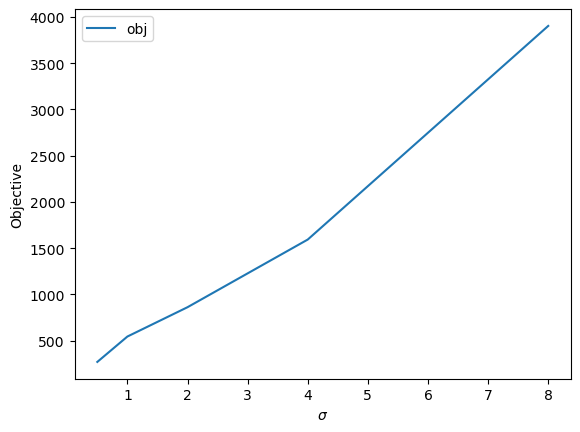

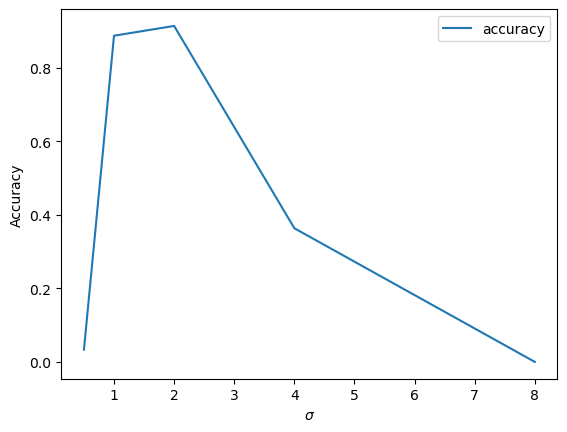

In [124]:
ax = results_kmeans.plot(x='s', y = 'obj')
ax.set_ylabel("Objective")
ax.set_xlabel(r"$\sigma$")
plt.savefig("./HW5_kmeans_sigma_vs_obj.png")

ax = results_kmeans.plot(x='s', y = 'accuracy')
ax.set_ylabel("Accuracy")
ax.set_xlabel(r"$\sigma$")
plt.savefig("./HW5_kmeans_sigma_vs_accuracy.png")

In [128]:
#GMM
#code from https://github.com/mr-easy/GMM-EM-Python/blob/master/GMM.py

from matplotlib.patches import Ellipse
import scipy

class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = np.random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = np.random.rand(k, 3)
        self.colors = colors
    
    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
        for i in range(k):
                self.sigma[i] = np.cov(self.data.T) + 1
    
    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        #print(self.data)
        for i in range(self.k):
            #print(scipy.stats.multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i], allow_singular=True).shape)
            self.z[:, i] = self.pi[i] * scipy.stats.multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i], allow_singular=True)
        self.z /= self.z.sum(axis=1, keepdims=True)
    
    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
            
    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
           
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * scipy.stats.multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i], allow_singular=True)
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)
            
def plot(title):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-12, 12))
    ax.set_ylim((-12, 12))
    
    plt.title(title)
    plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()

In [132]:

results_gmm = pd.DataFrame({'s':[], 'obj':[], 'accuracy':[]})
def run_gmm(data, k, dim, s):
    gmm = GMM(k, dim)
    # Training the GMM using EM

    # Initialize EM algo with data
    gmm.init_em(data[:,0:2])
    num_iters = 100
    # Saving log-likelihood
    log_likelihood = [gmm.log_likelihood(data[:,0:2])*(-1)]
    # plotting
    #plot("Iteration:  0")
    for e in range(num_iters):
        # E-step
        gmm.e_step()
        # M-step
        gmm.m_step()
        # Computing log-likelihood
        log_likelihood.append(gmm.log_likelihood(data[:,0:2])*(-1))
        print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
        # plotting
        #plot(title="Iteration: " + str(e+1))

    # Plot log-likelihood
    #plt.plot(log_likelihood[1:], marker='.')

    #calculate accuracy
    dis = d_centers2nodes(data[:,0:2], gmm.mu)
    index = np.argmin(dis, axis=1)
    mapping_df = pd.DataFrame(map_cluster_centers_to_dist(gmm.mu), columns = ['map', 'true']).astype(str)
    preds_unmapped = pd.DataFrame({'map': (index.astype(float)+1), 'row_index':(range(data.shape[0]))}).astype(str)
    mapping_df_joined = preds_unmapped.merge(mapping_df, on = 'map')
    accuracy = np.sum((mapping_df_joined['true']).to_numpy().astype(float)==data[:,2])/(data.shape[0])
    #accuracy = np.sum((index+1)==data[:,2])/(data.shape[0])
    return pd.concat([results_gmm, pd.DataFrame({'s':[s], 'obj':[log_likelihood[-1]], 'accuracy':[accuracy]})])

s05_gmm = run_gmm(data=X_s_half, k = 3, dim = 2, s = 0.5)
s1_gmm = run_gmm(data=X_s_1, k = 3, dim = 2, s = 1)
s2_gmm = run_gmm(data=X_s_2, k = 3, dim = 2, s = 2)
s4_gmm = run_gmm(data=X_s_4, k = 3, dim = 2, s = 4)
s8_gmm = run_gmm(data=X_s_8, k = 3, dim = 2, s = 8)

Iteration: 1, log-likelihood: 917.5615
Iteration: 2, log-likelihood: 912.2196
Iteration: 3, log-likelihood: 909.3618
Iteration: 4, log-likelihood: 907.4599
Iteration: 5, log-likelihood: 906.2643
Iteration: 6, log-likelihood: 905.5721
Iteration: 7, log-likelihood: 905.1791
Iteration: 8, log-likelihood: 904.9387
Iteration: 9, log-likelihood: 904.7631
Iteration: 10, log-likelihood: 904.6016
Iteration: 11, log-likelihood: 904.4245
Iteration: 12, log-likelihood: 904.2154
Iteration: 13, log-likelihood: 903.9684
Iteration: 14, log-likelihood: 903.6869
Iteration: 15, log-likelihood: 903.3801
Iteration: 16, log-likelihood: 903.0591
Iteration: 17, log-likelihood: 902.7331
Iteration: 18, log-likelihood: 902.4100
Iteration: 19, log-likelihood: 902.0965
Iteration: 20, log-likelihood: 901.7977
Iteration: 21, log-likelihood: 901.5171
Iteration: 22, log-likelihood: 901.2561
Iteration: 23, log-likelihood: 901.0147
Iteration: 24, log-likelihood: 900.7922
Iteration: 25, log-likelihood: 900.5876
Iteration

Iteration: 1, log-likelihood: 1216.8434
Iteration: 2, log-likelihood: 1210.1581
Iteration: 3, log-likelihood: 1207.5102
Iteration: 4, log-likelihood: 1206.0676
Iteration: 5, log-likelihood: 1205.0972
Iteration: 6, log-likelihood: 1204.3229
Iteration: 7, log-likelihood: 1203.5953
Iteration: 8, log-likelihood: 1202.7779
Iteration: 9, log-likelihood: 1201.6159
Iteration: 10, log-likelihood: 1199.6767
Iteration: 11, log-likelihood: 1197.6556
Iteration: 12, log-likelihood: 1196.7813
Iteration: 13, log-likelihood: 1196.0148
Iteration: 14, log-likelihood: 1195.7005
Iteration: 15, log-likelihood: 1195.4277
Iteration: 16, log-likelihood: 1195.1669
Iteration: 17, log-likelihood: 1194.9175
Iteration: 18, log-likelihood: 1194.6798
Iteration: 19, log-likelihood: 1194.4540
Iteration: 20, log-likelihood: 1194.2407
Iteration: 21, log-likelihood: 1194.0398
Iteration: 22, log-likelihood: 1193.8515
Iteration: 23, log-likelihood: 1193.6756
Iteration: 24, log-likelihood: 1193.5119
Iteration: 25, log-likeli

Iteration: 5, log-likelihood: 1629.8580
Iteration: 6, log-likelihood: 1629.6081
Iteration: 7, log-likelihood: 1629.3861
Iteration: 8, log-likelihood: 1629.1846
Iteration: 9, log-likelihood: 1629.0076
Iteration: 10, log-likelihood: 1628.8593
Iteration: 11, log-likelihood: 1628.7397
Iteration: 12, log-likelihood: 1628.6453
Iteration: 13, log-likelihood: 1628.5713
Iteration: 14, log-likelihood: 1628.5132
Iteration: 15, log-likelihood: 1628.4669
Iteration: 16, log-likelihood: 1628.4296
Iteration: 17, log-likelihood: 1628.3989
Iteration: 18, log-likelihood: 1628.3731
Iteration: 19, log-likelihood: 1628.3511
Iteration: 20, log-likelihood: 1628.3319
Iteration: 21, log-likelihood: 1628.3148
Iteration: 22, log-likelihood: 1628.2994
Iteration: 23, log-likelihood: 1628.2852
Iteration: 24, log-likelihood: 1628.2719
Iteration: 25, log-likelihood: 1628.2594
Iteration: 26, log-likelihood: 1628.2475
Iteration: 27, log-likelihood: 1628.2360
Iteration: 28, log-likelihood: 1628.2249
Iteration: 29, log-li

In [134]:
gmm_results_all = pd.concat([s05_gmm, s1_gmm, s2_gmm, s4_gmm, s8_gmm]); gmm_results_all

,s,obj,accuracy
0,0.5,896.251716,0.083333
0,1.0,1064.461006,0.706667
0,2.0,1191.741498,0.543333
0,4.0,1390.757216,0.363333
0,8.0,1627.782699,0.000000


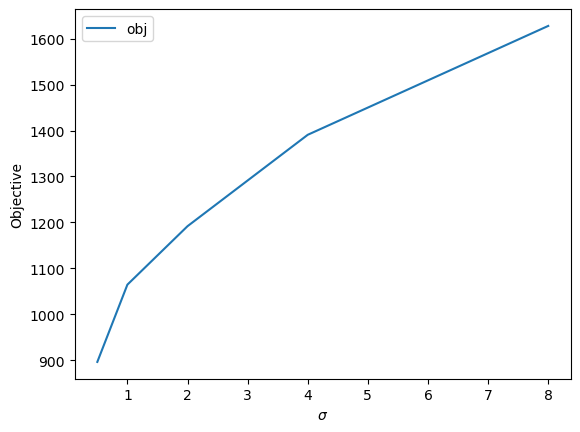

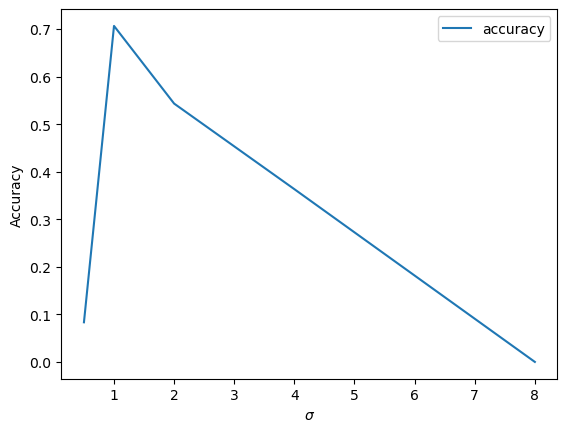

In [135]:
ax = gmm_results_all.plot(x='s', y = 'obj')
ax.set_ylabel("Objective")
ax.set_xlabel(r"$\sigma$")
plt.savefig("./HW5_gmm_sigma_vs_obj.png")

ax = gmm_results_all.plot(x='s', y = 'accuracy')
ax.set_ylabel("Accuracy")
ax.set_xlabel(r"$\sigma$")
plt.savefig("./HW5_gmm_sigma_vs_accuracy.png")

In [219]:
#import data
data2D = pd.read_csv("./data 2/data2D.csv", header=None).to_numpy()


data1000D = pd.read_csv("./data 2/data1000D.csv", header=None).to_numpy()


In [256]:
#section 2.3
#buggy PCA
#code from https://www.askpython.com/python/examples/principal-component-analysis
import numpy as np
import math

def calc_reconstruction_error(orig_matrix, reconstructed_matrix):
    r_error = 0
    r_error = np.sum(np.square(orig_matrix-reconstructed_matrix))/(orig_matrix.shape[0])
    #for i in range(orig_matrix.shape[0]):
    #    #r_error += (orig_matrix[i,j]-reconstructed_matrix[i,j])**2
    #    r_error += math.dist(orig_matrix,reconstructed_matrix)
    return r_error
            

def PCA_demean(X , num_components):
    #Step-1
    X_meaned = X - np.mean(X , axis = 0)
    
    #Step-2
    #cov_mat = np.cov(X_meaned , rowvar = False)
    
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(np.dot(X_meaned.T, X_meaned))
    
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]

    #Step-6
    X_reduced = (np.dot(np.dot(X_meaned, eigenvector_subset) , eigenvector_subset.T))+ np.mean(X, axis = 0)
    
    #calculate reconstruction error
    r_error = calc_reconstruction_error(X, X_reduced)
    print(r_error)
            
    return eigenvector_subset, X_reduced, r_error


def PCA_buggy(X , num_components):
    #Step-1
    #X_meaned = X - np.mean(X , axis = 0)
    
    #Step-2
    #cov_mat = np.cov(X , rowvar = False)
    
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(np.dot(X.T, X))
    
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]

    #Step-6
    X_reduced_bug = (np.dot(np.dot(X, eigenvector_subset) , eigenvector_subset.T))
    print(X_reduced_bug.shape)
    #calculate reconstruction error
    r_error = calc_reconstruction_error(X, X_reduced_bug)
    return eigenvector_subset, X_reduced_bug, r_error

def PCA_normal(X, num_components):
    #Step-1
    X_meaned = X - np.mean(X , axis = 0)
    X_meaned_std = X_meaned/np.std(X, axis = 0)
    #Step-2
    #cov_mat = np.cov(X_meaned_std, rowvar = False)
    
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(np.dot(X_meaned_std.T, X_meaned_std))
    
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]

    #Step-6
    X_reduced = (np.dot(np.dot(X_meaned_std, eigenvector_subset) , eigenvector_subset.T))*np.std(X, axis=0) + np.mean(X, axis = 0)
    #calculate reconstruction error
    r_error = calc_reconstruction_error(X, X_reduced)
    #print(r_error)
            
    return eigenvector_subset, X_reduced, r_error

def DRO(X, num_components):
    X_demean = X - np.mean(X, axis = 0)
    U, S, Vh = np.linalg.svd(X_demean, full_matrices=True)
    print(S)
    plt.scatter(x = np.arange(len(S)), y = S)
    plt.savefig("./HW5_dro_d1000_elbow_plot.png")
    smat = np.zeros((X.shape[0], X.shape[1]), dtype=complex)
    smat[:(len(S)), :(len(S))] = np.diag(S)
    #S = np.diag(S)
    smat[:,num_components:] = 0
    Vh[(num_components):,:] = 0

    X_reduced = np.dot(Vh.T, np.dot(U, smat).T).T + np.mean(X, axis = 0)
    r_error = calc_reconstruction_error(X, X_reduced)
    print(r_error)
    return U, S, Vh, r_error, X_reduced

In [232]:
demean = PCA_demean(data2D, 1)
buggy = PCA_buggy(data2D, 1)
normal = PCA_normal(data2D, 1)
dro = DRO(data2D, 1)

0.010006085628512905
(50, 2)
(50, 2)
(50, 50)
(2,)
(2, 2)
[[-0.9755276   0.21987702]
 [ 0.          0.        ]]
(0.010006085628512927+0j)


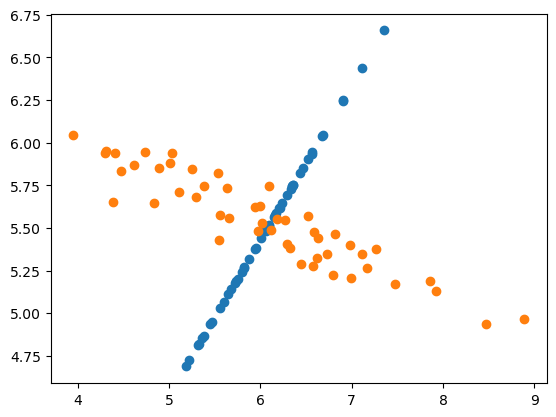

In [159]:
#plt.plot( buggy[1][0],buggy[1][1])
data = buggy[1]
plt.scatter(data[:,0], data[:,1])
plt.scatter(data2D[:,0], data2D[:,1])
plt.savefig("HW5_buggyPCA_reconstruction")


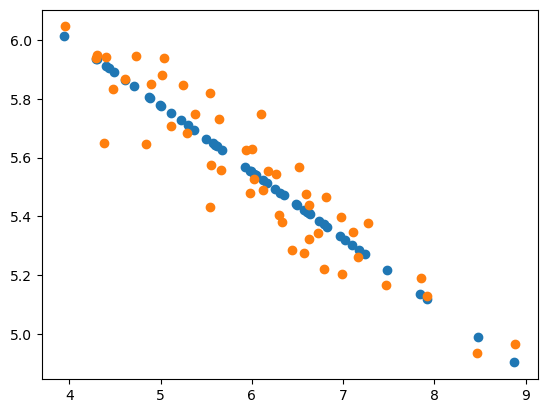

In [160]:
data = demean[1]
plt.scatter(data[:,0], data[:,1])
plt.scatter(data2D[:,0], data2D[:,1])
plt.savefig("HW5_demeanPCA_reconstruction.png")

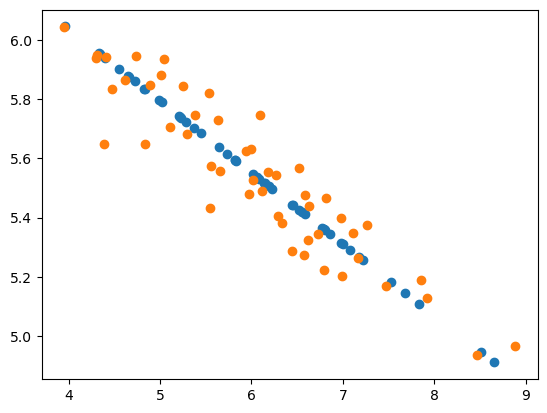

In [161]:
data = normal[1]
plt.scatter(data[:,0], data[:,1])
plt.scatter(data2D[:,0], data2D[:,1])
plt.savefig("HW5_normal_PCA_reconstruction.png")

[[7.24489297+0.j 5.2706226 +0.j]
 [4.30239915+0.j 5.93383989+0.j]
 [5.00194577+0.j 5.77616703+0.j]
 [7.48368071+0.j 5.21680153+0.j]
 [6.31212467+0.j 5.48086197+0.j]
 [5.61402111+0.j 5.63820958+0.j]
 [5.57041649+0.j 5.64803775+0.j]
 [4.87220122+0.j 5.80541053+0.j]
 [6.16896052+0.j 5.51313016+0.j]
 [5.22289216+0.j 5.72636727+0.j]
 [6.73403951+0.j 5.38576535+0.j]
 [4.61101005+0.j 5.86428117+0.j]
 [6.12522153+0.j 5.52298862+0.j]
 [6.96718361+0.j 5.33321632+0.j]
 [5.36719254+0.j 5.69384299+0.j]
 [6.4913764 +0.j 5.4404599 +0.j]
 [5.98001002+0.j 5.55571827+0.j]
 [5.50135478+0.j 5.66360377+0.j]
 [5.67379245+0.j 5.62473754+0.j]
 [7.17286051+0.j 5.2868582 +0.j]
 [6.04829966+0.j 5.54032626+0.j]
 [6.79080321+0.j 5.37297122+0.j]
 [6.64030842+0.j 5.40689168+0.j]
 [6.35012591+0.j 5.47229676+0.j]
 [7.91581003+0.j 5.11940264+0.j]
 [3.94513184+0.j 6.01436541+0.j]
 [4.29449899+0.j 5.93562052+0.j]
 [4.71143974+0.j 5.84164503+0.j]
 [7.10120088+0.j 5.30300978+0.j]
 [6.25534008+0.j 5.49366082+0.j]
 [5.926760

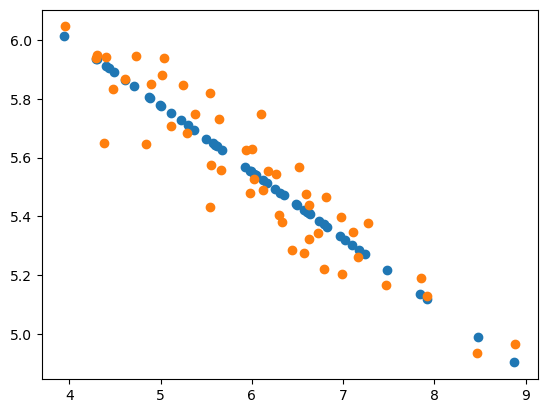

In [215]:
data = dro[4]
plt.scatter(data[:,0], data[:,1])
plt.scatter(data2D[:,0], data2D[:,1])
plt.savefig("HW5_dro_PCA_reconstruction.png")

In [218]:
results_df_reconstruction = pd.DataFrame({'method':('buggy', 'demean', 'normalized', 'DRO'), 'reconstruction_error': (buggy[2], demean[2], normal[2], dro[3])})
print(results_df_reconstruction.to_latex())

\begin{tabular}{llr}
\toprule
{} &      method &  reconstruction\_error \\
\midrule
0 &       buggy &    0.886903+0.000000j \\
1 &      demean &    0.010006+0.000000j \\
2 &  normalized &    0.049472+0.000000j \\
3 &         DRO &    0.010006+0.000000j \\
\bottomrule
\end{tabular}



/var/folders/b2/8cn96b9x6qz0b7b79dn_n_1h0000gn/T/ipykernel_20365/783187947.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df_reconstruction.to_latex())


[9.06944618e+02 8.99347183e+02 8.56076283e+02 8.21124899e+02
 8.20941909e+02 8.09725103e+02 7.78287025e+02 7.54747926e+02
 7.52025322e+02 7.40945148e+02 7.37311909e+02 7.25317273e+02
 7.03714353e+02 6.89223149e+02 6.85707405e+02 6.81073486e+02
 6.70649100e+02 6.60404143e+02 6.51842805e+02 6.41349697e+02
 6.32373122e+02 6.13864407e+02 6.05868033e+02 5.93571322e+02
 5.78347228e+02 5.71368731e+02 5.62886549e+02 5.57535429e+02
 5.41100841e+02 5.14786013e+02 2.87259008e+01 2.85120739e+01
 2.81959508e+01 2.80560462e+01 2.79991410e+01 2.77824398e+01
 2.77017621e+01 2.75286948e+01 2.74936594e+01 2.74401571e+01
 2.72902562e+01 2.72492343e+01 2.71350084e+01 2.70841984e+01
 2.69141735e+01 2.68692938e+01 2.67396137e+01 2.67087864e+01
 2.65392776e+01 2.64877420e+01 2.64570125e+01 2.63973391e+01
 2.63338370e+01 2.62486277e+01 2.60961398e+01 2.60634331e+01
 2.59133949e+01 2.59096981e+01 2.58061992e+01 2.57893736e+01
 2.57328049e+01 2.56564097e+01 2.56246685e+01 2.55343445e+01
 2.53935575e+01 2.534668

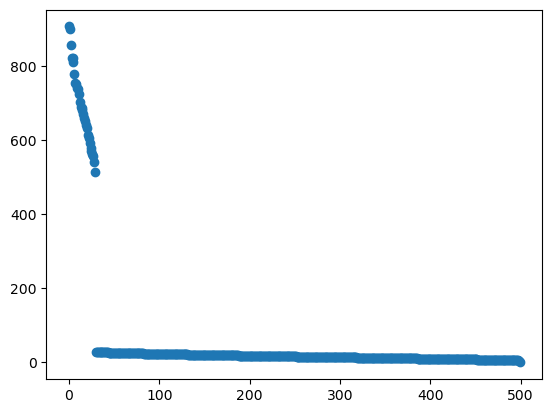

In [257]:
dro_1000 = DRO(data1000D, 1000)

273.0459589786028
(500, 1000)
[9.06944618e+02 8.99347183e+02 8.56076283e+02 8.21124899e+02
 8.20941909e+02 8.09725103e+02 7.78287025e+02 7.54747926e+02
 7.52025322e+02 7.40945148e+02 7.37311909e+02 7.25317273e+02
 7.03714353e+02 6.89223149e+02 6.85707405e+02 6.81073486e+02
 6.70649100e+02 6.60404143e+02 6.51842805e+02 6.41349697e+02
 6.32373122e+02 6.13864407e+02 6.05868033e+02 5.93571322e+02
 5.78347228e+02 5.71368731e+02 5.62886549e+02 5.57535429e+02
 5.41100841e+02 5.14786013e+02 2.87259008e+01 2.85120739e+01
 2.81959508e+01 2.80560462e+01 2.79991410e+01 2.77824398e+01
 2.77017621e+01 2.75286948e+01 2.74936594e+01 2.74401571e+01
 2.72902562e+01 2.72492343e+01 2.71350084e+01 2.70841984e+01
 2.69141735e+01 2.68692938e+01 2.67396137e+01 2.67087864e+01
 2.65392776e+01 2.64877420e+01 2.64570125e+01 2.63973391e+01
 2.63338370e+01 2.62486277e+01 2.60961398e+01 2.60634331e+01
 2.59133949e+01 2.59096981e+01 2.58061992e+01 2.57893736e+01
 2.57328049e+01 2.56564097e+01 2.56246685e+01 2.5534344

/var/folders/b2/8cn96b9x6qz0b7b79dn_n_1h0000gn/T/ipykernel_20365/2731307508.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df_reconstruction1000.to_latex())


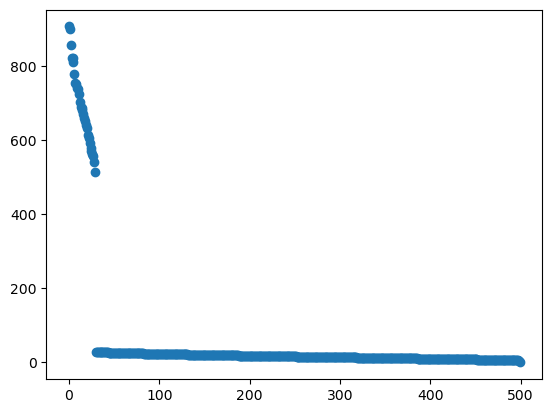

In [259]:
demean1000 = PCA_demean(data1000D, 30)
buggy1000 = PCA_buggy(data1000D, 30)
normal1000 = PCA_normal(data1000D, 30)
dro1000 = DRO(data1000D, 30)

results_df_reconstruction1000 = pd.DataFrame({'method':('buggy', 'demean', 'normalized', 'DRO'), 'reconstruction_error': (buggy1000[2], demean1000[2], normal1000[2], dro1000[3])})
print(results_df_reconstruction1000.to_latex())